# Import Modules

In [19]:
import torch
import torch.nn as nn
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.animation import FuncAnimation

from torch import Tensor
from numpy import ndarray
from typing import Type

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Import Data and Data Processing

In [20]:
tree = ET.parse("./data/O-A0038-003.xml")
root = tree.getroot()
ns = {"ns": "urn:cwa:gov:tw:cwacommon:0.1"}

# template data
data = np.array([
    [float(temp) for temp in row.split(',')]
    for row in root.find("./ns:dataset/ns:Resource/ns:Content", ns).text.split('\n')
])

# long_min, long_max, lat_min, lat_max, template_min, template_max
dataRange = [
    float(root.find("./ns:dataset/ns:GeoInfo/ns:{0}".format(tag), ns).text)
    for tag in [
        "BottomLeftLongitude",
        "TopRightLongitude",
        "BottomLeftLatitude",
        "TopRightLatitude"
    ]
] + [
    np.min(np.where(data == -999, np.inf, data)),
    np.max(data)
]

# long & lat grid
lat_grid, long_grid = np.mgrid[dataRange[3]:dataRange[2]:120j, dataRange[0]:dataRange[1]:67j]
ll_grid = np.concat((long_grid[..., np.newaxis], lat_grid[..., np.newaxis]), axis=-1)

# Classification dataset (long, lat, label)
classData = np.array([
    [long_grid[i, j], lat_grid[i, j], 0 if data[i, j] == -999 else 1]
    for i in range(120)
    for j in range(67)
])

# Regression dataset (long, lat, value)
regData = np.array([
    [long_grid[i, j], lat_grid[i, j], data[i, j]]
    for i in range(120)
    for j in range(67)
    if data[i, j] != -999
])

### Normalize Data

In [21]:
def normalize(x: float, _min: float, _max: float) -> float:
    return (x - _min) / (_max - _min)

def unnormalize(x: float, _min: float, _max: float) -> float:
    return x * (_max - _min) + _min

# Classification dataset
classData_N = np.zeros((len(classData), len(classData[0])))
classData_N[:, 0] = normalize(classData[:, 0], dataRange[0], dataRange[1])
classData_N[:, 1] = normalize(classData[:, 1], dataRange[2], dataRange[3])
classData_N[:, 2] = classData[:, 2]

# Regression dataset
regData_N = np.zeros((len(regData), len(regData[0])))
regData_N[:, 0] = normalize(regData[:, 0], dataRange[0], dataRange[1])
regData_N[:, 1] = normalize(regData[:, 1], dataRange[2], dataRange[3])
regData_N[:, 2] = normalize(regData[:, 2], dataRange[4], dataRange[5])

# DataSet

In [22]:
def tvt_split(arr: ndarray) -> tuple:
    idx   = np.random.permutation(len(arr))
    n     = int(0.1*len(arr))
    train = arr[idx[2*n:]]
    valid = arr[idx[:n]]
    test  = arr[idx[n:2*n]]
    return train, valid, test

def toTensor(arr: ndarray) -> Tensor:
    return torch.tensor(arr, dtype=torch.float32, device=device)

class BasicDataSet(torch.utils.data.Dataset):
    def __init__(self, _data: ndarray) -> None:
        self.data : ndarray = _data.copy()
        self.X    : ndarray = self.data[:, :2]
        self.X_t  : Tensor  = toTensor(self.X)
    
    def __len__(self):
        return len(self.data)

class NormalDataSet(BasicDataSet):
    def __init__(self, _data: ndarray) -> None:
        super(NormalDataSet, self).__init__(_data)
        self.Y  : ndarray = self.data[:, 2:]
        self.Y_t: Tensor  = toTensor(self.Y)
    
    def __getitem__(self, idx):
        return self.X_t[idx], self.Y_t[idx]

class OneHotDataSet(BasicDataSet):
    def __init__(self, _data: ndarray) -> None:
        super(OneHotDataSet, self).__init__(_data)
        self.Y  : ndarray = np.array([[1, 0] if row[2] == 0 else [0, 1] for row in self.data])
        self.Y_t: Tensor  = toTensor(self.Y)
    
    def __getitem__(self, idx):
        return self.X_t[idx], self.Y_t[idx]

class DataSet:
    def __init__(self, _data: ndarray, _bds: Type[BasicDataSet], _batchSize: int) -> None:
        self.data : ndarray = _data.copy()
        self.train: Type[BasicDataSet]
        self.valid: Type[BasicDataSet]
        self.test : Type[BasicDataSet]
        self.train, self.valid, self.test = tuple(_bds(splitdata) for splitdata in tvt_split(self.data))

        self.loader = torch.utils.data.DataLoader(self.train, batch_size=_batchSize, shuffle=True)

classDS = DataSet(classData_N, NormalDataSet, 128)
regDS   = DataSet(regData_N  , NormalDataSet, 128)

# Display Args definition

In [23]:
size_times = 4
x_size, y_size = 67*size_times, 120*size_times
y, x     = np.mgrid[dataRange[3]:dataRange[2]:y_size*1j, dataRange[0]:dataRange[1]:x_size*1j]
grid     = np.concat((x[..., np.newaxis], y[..., np.newaxis]), axis=-1)
y_N, x_N = np.mgrid[1:0:y_size*1j, 0:1:x_size*1j]
grid_N   = np.concat((x_N[..., np.newaxis], y_N[..., np.newaxis]), axis=-1)

xtick_org = list(range(0, 67, 20))
ytick_org = list(range(0, 120, 20))
xtick_label_org = [f"{long_grid[0, i]:.2f}" for i in xtick_org]
ytick_label_org = [f"{lat_grid[-i-1, 0]:.2f}" for i in ytick_org]

xtick_res = list(range(0, x_size, 20*size_times))
ytick_res = list(range(0, y_size, 20*size_times))
xtick_label_res = [f"{long_grid[0, i//size_times]:.2f}" for i in xtick_res]
ytick_label_res = [f"{lat_grid[-i//size_times-1, 0]:.2f}" for i in ytick_res]

# Problem 1: GDA Classification

In [186]:
class GDA:
    def fit(self, X, y) -> None:
        self.classes: ndarray = np.unique(y)
        self.priors : dict = {}
        self.means  : dict = {}
        self.covs   : dict = {}

        for c in self.classes:
            Xc = X[y == c]
            n_c = Xc.shape[0]
            
            self.priors[c] = n_c / len(y)
            self.means[c]  = np.mean(Xc, axis=0)
            self.covs[c]   = np.cov(Xc, rowvar=False, ddof=0)

    def predict(self, X) -> ndarray:
        posteriors = []
        for c in self.classes:
            prior = self.priors[c]
            mean  = self.means[c]
            cov   = self.covs[c]
            
            det_cov = np.linalg.det(cov)
            inv_cov = np.linalg.inv(cov)
            d = X.shape[1]
            
            log_pdf = -0.5 * np.sum((X - mean) @ inv_cov * (X - mean), axis=1)
            log_pdf -= 0.5 * (d * np.log(2 * np.pi) + np.log(det_cov))
            
            posteriors.append(log_pdf + np.log(prior))
            
        return self.classes[np.argmax(posteriors, axis=0)]

gdaModel = GDA()
gdaModel.fit(classDS.train.X, classDS.train.Y.squeeze())

y_pred_1 = gdaModel.predict(classDS.valid.X)
y_pred_2 = gdaModel.predict(classDS.test.X)
accuracy = (np.mean(y_pred_1 == classDS.valid.Y.squeeze()) +
            np.mean(y_pred_2 == classDS.test.Y.squeeze())) / 2
print("Test set's accurary: ", accuracy)

Test set's accurary:  0.8470149253731343


## Display Data Preparation

In [187]:
# origin data
plot_data_1 = np.where(data==-999, np.nan, 1)

# GDA result
y_pred = gdaModel.predict(grid_N.reshape(-1, 2))
plot_data_2 = y_pred.reshape(y_size, x_size)

## Display Result

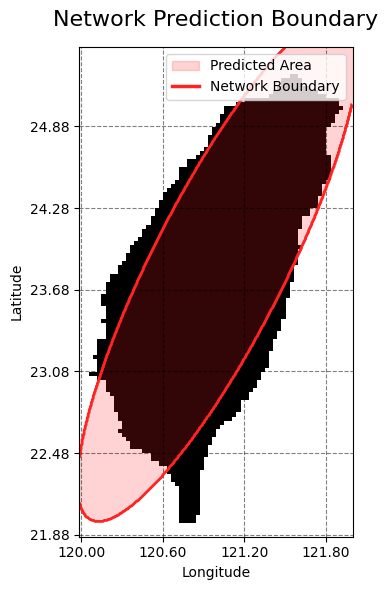

In [188]:
plt.figure(figsize=(5, 6))
ax = plt.gca()

im = ax.imshow(plot_data_1, origin='lower', cmap='Greys',
               vmin=0, vmax=1, interpolation='bilinear')

h_high, w_high = plot_data_2.shape
h_low, w_low   = plot_data_1.shape
x_coords_scaled = (np.arange(w_high) + 0.5) * (w_low / w_high) - 0.5
y_coords_scaled = (np.arange(h_high) + 0.5) * (h_low / h_high) - 0.5
xx_scaled, yy_scaled = np.meshgrid(x_coords_scaled, y_coords_scaled)

ax.contourf(xx_scaled, yy_scaled, plot_data_2, levels=[0.5, 1.0],
            colors="#FF2323", alpha=0.2)
ax.contour(xx_scaled, yy_scaled, plot_data_2, levels=[0.5],
           colors="#FF2323", linewidths=2.0)

ax.set_title("Network Prediction Boundary", fontsize=16, pad=15)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_xticks(xtick_org)
ax.set_yticks(ytick_org)
ax.set_xticklabels(xtick_label_org)
ax.set_yticklabels(ytick_label_org)
ax.grid(True, linestyle='--', alpha=0.5, color='black')

legend_elements = [
    plt.Rectangle((0,0), 1, 1, color='#FF2323', alpha=0.2, label='Predicted Area'),
    Line2D([0], [0], color='#FF2323', lw=2.5, label='Network Boundary')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig(f"./figure/gda_result.png", dpi=300, bbox_inches='tight')
plt.show()

# Problem 2: Regression by Network

## Network

In [27]:
class ClassModel(nn.Module):
    def __init__(self) -> None:
        super(ClassModel, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, X):
        return self.seq(X)

class RegModel(nn.Module):
    def __init__(self) -> None:
        super(RegModel, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    
    def forward(self, X):
        return self.seq(X)

## Models

In [123]:
cls_net        = ClassModel()
cls_criterion  = nn.BCEWithLogitsLoss()
cls_optimizer  = torch.optim.Adam(cls_net.parameters(), lr=0.01)
cls_trainEpoch = 500

reg_net        = RegModel()
reg_criterion  = nn.MSELoss()
reg_optimizer  = torch.optim.Adam(reg_net.parameters(), lr=0.01)
reg_trainEpoch = 500

# Combine Model

In [124]:
class CombineModel:
    def __init__(self, _ani: bool = True, _grid: ndarray = grid_N) -> None:
        self.ani : bool     = _ani
        self.grid: ndarray  = _grid
        self.grid_t: Tensor = toTensor(self.grid)
        
        self.cls_trainlosslist: list = []
        self.cls_validlosslist: list = []
        self.reg_trainlosslist: list = []
        self.reg_validlosslist: list = []

        self.cls_res: list[ndarray] = []
        self.reg_res: list[ndarray] = []
    
    def __forward(self, mode: str) -> None:
        if mode == "class":
            cls_res_l = []
            for row in self.grid_t:
                cls_res_l.append(list(cls_net(row).detach().numpy().squeeze()))
            cls_res_n = np.array(cls_res_l)
            self.cls_res.append(np.where(cls_res_n < 0.5, 0, 1))
        elif mode == "reg":
            reg_res_l = []
            for row in self.grid_t:
                reg_res_l.append(list(reg_net(row).detach().numpy().squeeze()))
            reg_res_n = np.array(reg_res_l)
            self.reg_res.append(np.array(unnormalize(reg_res_n, dataRange[4], dataRange[5])))
    
    def __trainingFunc(self, mode: str) -> None:
        DS: DataSet
        net: any
        criterion: any
        optimizer: any
        trainEpoch: int
        trainlosslist: list
        validlosslist: list

        if mode == "class":
            DS            = classDS
            net           = cls_net
            criterion     = cls_criterion
            optimizer     = cls_optimizer
            trainEpoch    = cls_trainEpoch
            trainlosslist = self.cls_trainlosslist
            validlosslist = self.cls_validlosslist
        elif mode == "reg":
            DS            = regDS
            net           = reg_net
            criterion     = reg_criterion
            optimizer     = reg_optimizer
            trainEpoch    = reg_trainEpoch
            trainlosslist = self.reg_trainlosslist
            validlosslist = self.reg_validlosslist
        else:
            print("mode error!")
            return
        
        self.__forward("class")
        self.__forward("reg")

        print("┌───────┬───────────┬───────────┐")
        print("│ Epoch │ trainLoss │ validLoss │")
        print("├───────┼───────────┼───────────┤")

        for epoch in range(trainEpoch):
            # train data
            for batch_X, batch_Y in DS.loader:
                optimizer.zero_grad()
                y_train = net(batch_X)
                trainloss = criterion(y_train, batch_Y)
                trainloss.backward()
                optimizer.step()

            # valid data
            y_valid = net(DS.valid.X_t)
            validloss = criterion(y_valid, DS.valid.Y_t)

            # record
            trainlosslist.append(trainloss.item())
            validlosslist.append(validloss.item())

            if epoch % (trainEpoch // 10) == 0:
                print("│ {0:5d} │ {1:9.5f} │ {2:9.5f} │".format(epoch+1, trainloss.item(), validloss.item()))
            
            if self.ani:
                if mode == "class":
                    self.__forward("class")
                elif mode == "reg":
                    self.__forward("reg")
        
        print("| Final | {0:9.5f} │ {1:9.5f} │".format(trainlosslist[-1], validlosslist[-1]))
        print("└───────┴───────────┴───────────┘")
        return trainlosslist, validlosslist

    def __drawLossCurve(self, mode: str) -> None:
        trainlosslist: list
        validlosslist: list

        if mode == "class":
            trainlosslist = self.cls_trainlosslist
            validlosslist = self.cls_validlosslist
        elif mode == "reg":
            trainlosslist = self.reg_trainlosslist
            validlosslist = self.reg_validlosslist
        else:
            print("mode error!")
            return

        epochlist = np.arange(len(trainlosslist))
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))

        axes[0].plot(epochlist, trainlosslist, label='trainLoss')
        axes[0].plot(epochlist, validlosslist, label='validLoss')
        axes[0].legend()
        axes[0].grid(True)
        axes[0].set_title("Loss curves")

        axes[1].plot(epochlist, trainlosslist, label='trainLoss')
        axes[1].plot(epochlist, validlosslist, label='validLoss')
        axes[1].set_yscale('log')
        axes[1].legend()
        axes[1].grid(True)
        axes[1].set_title("Loss curves (logarithmic scale)")

        plt.tight_layout()
        plt.savefig(f"./figure/{mode}_loss.png", dpi=300, bbox_inches='tight')
        plt.show()

    
    def train_class(self) -> ndarray:
        self.__trainingFunc("class")
    
    def train_reg(self) -> ndarray:
        self.__trainingFunc("reg")
    
    def curve_class(self) -> None:
        self.__drawLossCurve("class")
    
    def curve_reg(self) -> None:
        self.__drawLossCurve("reg")
    
    def drawAni(self, _dir: str) -> None:
        plot_data = np.where(self.cls_res[0] == 1, self.reg_res[0], np.nan)

        fig, axes = plt.subplots(figsize=(5, 6))
        im = axes.imshow(plot_data, origin='lower', cmap='jet', 
                         vmin=0, vmax=30, interpolation='nearest')
        fig.colorbar(im, ax=axes, label="Temperature (°C)")
        axes.set_title("Network Result | Epoch:   0")
        axes.set_xlabel("Longitude")
        axes.set_ylabel("Latitude")
        axes.set_xticks(xtick_res)
        axes.set_yticks(ytick_res)
        axes.set_xticklabels(xtick_label_res)
        axes.set_yticklabels(ytick_label_res)

        def update(frame):
            plot_data = np.where(
                self.cls_res[min(frame, len(self.cls_res))] == 1,
                self.reg_res[min(frame, len(self.reg_res))],
                np.nan
            )

            axes.clear()
            im = axes.imshow(plot_data, origin='lower', cmap='jet', 
                            vmin=0, vmax=30, interpolation='nearest')
            axes.set_title(f"Network Result | Epoch: {frame:3d}")
            axes.set_xlabel("Longitude")
            axes.set_ylabel("Latitude")
            axes.set_xticks(xtick_res)
            axes.set_yticks(ytick_res)
            axes.set_xticklabels(xtick_label_res)
            axes.set_yticklabels(ytick_label_res)
        
        ani = FuncAnimation(fig, update, frames=max(len(self.cls_res), len(self.reg_res)), interval=100)
        ani.save(_dir, writer='pillow', fps=24)
        plt.close()

## Model create

In [125]:
model = CombineModel()

## Training

### Classification

┌───────┬───────────┬───────────┐
│ Epoch │ trainLoss │ validLoss │
├───────┼───────────┼───────────┤
│     1 │   0.10890 │   0.18026 │
│    51 │   0.07209 │   0.07541 │
│   101 │   0.06655 │   0.05232 │
│   151 │   0.06921 │   0.05640 │
│   201 │   0.07299 │   0.05541 │
│   251 │   0.02613 │   0.05130 │
│   301 │   0.01457 │   0.06752 │
│   351 │   0.02600 │   0.05878 │
│   401 │   0.04714 │   0.05396 │
│   451 │   0.05963 │   0.06951 │
| Final |   0.01059 │   0.04316 │
└───────┴───────────┴───────────┘


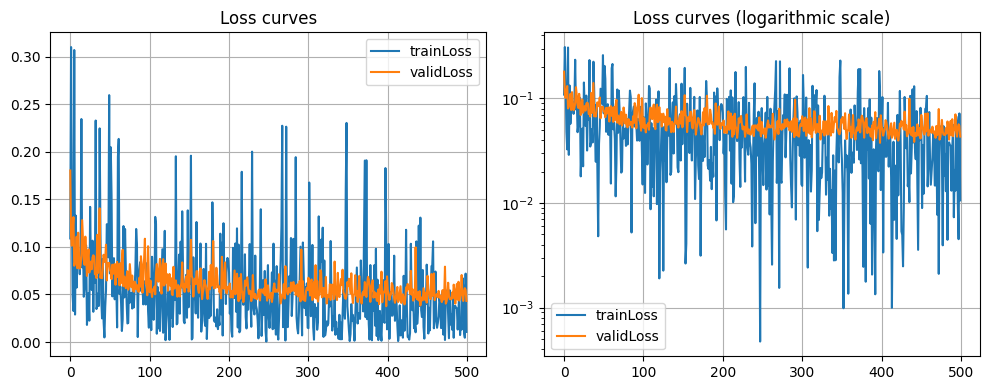

In [126]:
model.train_class()
model.curve_class()

### Regression

┌───────┬───────────┬───────────┐
│ Epoch │ trainLoss │ validLoss │
├───────┼───────────┼───────────┤
│     1 │   0.03696 │   0.02930 │
│    51 │   0.00782 │   0.00887 │
│   101 │   0.00774 │   0.00692 │
│   151 │   0.00705 │   0.00685 │
│   201 │   0.00440 │   0.00679 │
│   251 │   0.00681 │   0.00690 │
│   301 │   0.00667 │   0.00669 │
│   351 │   0.00518 │   0.00640 │
│   401 │   0.00491 │   0.00683 │
│   451 │   0.00641 │   0.00843 │
| Final |   0.00376 │   0.00603 │
└───────┴───────────┴───────────┘


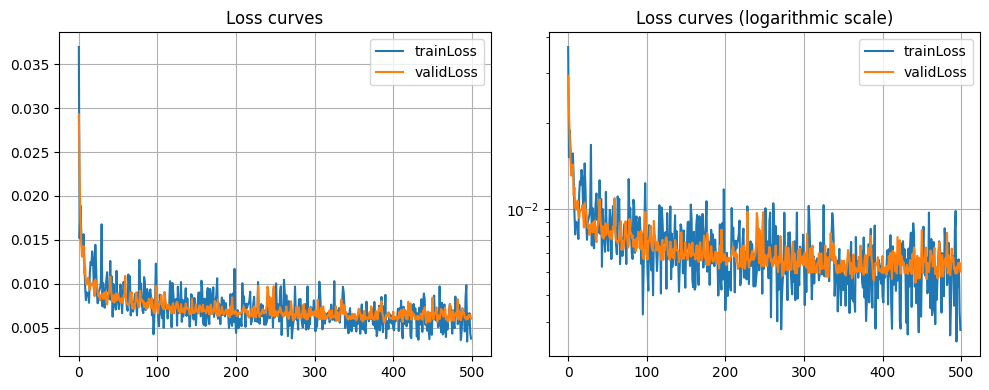

In [127]:
model.train_reg()
model.curve_reg()

# Complete Black Box

It will be passed in unnormalized latitude and longitude data and will pass out unnormalized results

In [155]:
class Predictor:
    def __init__(self, _input: ndarray, _normalize: bool = True) -> None:
        self.input  : ndarray = _input.copy()
        self.input_N: ndarray = self.input.copy()
        if _normalize:
            self.input_N[..., 0]  = normalize(self.input[..., 0], dataRange[0], dataRange[1])
            self.input_N[..., 1]  = normalize(self.input[..., 1], dataRange[2], dataRange[3])
        self.input_t: Tensor  = toTensor(self.input_N)

        self.cls_res: ndarray
        self.reg_res: ndarray
        self.result : ndarray
    
    def forward(self) -> ndarray:
        if(self.input.ndim == 2):
            self.forward_list()
        elif(self.input.ndim == 3):
            self.forward_grid()
        else:
            print("ndim error!")
        return self.result
    
    def forward_list(self) -> None:
        cls_res_t = cls_net(self.input_t)
        cls_res_n = cls_res_t.detach().numpy().squeeze()
        cls_res_l = [0 if row < 0.5 else 1 for row in cls_res_n]
        self.cls_res = np.array(cls_res_l)

        reg_res_t = reg_net(self.input_t)
        reg_res_n = reg_res_t.detach().numpy().squeeze()
        self.reg_res = np.array(unnormalize(reg_res_n, dataRange[4], dataRange[5]))

        self.result = np.where(self.cls_res == 1, self.reg_res, -999)
    
    def forward_grid(self) -> None:
        cls_res_l = []
        for row in self.input_t:
            cls_res_l.append(list(cls_net(row).detach().numpy().squeeze()))
        cls_res_n = np.array(cls_res_l)
        self.cls_res = np.where(cls_res_n < 0.5, 0, 1)

        reg_res_l = []
        for row in self.input_t:
            reg_res_l.append(list(reg_net(row).detach().numpy().squeeze()))
        reg_res_n = np.array(reg_res_l)
        self.reg_res = np.array(unnormalize(reg_res_n, dataRange[4], dataRange[5]))

        self.result = np.where(self.cls_res == 1, self.reg_res, -999)

## Test Case

In [183]:
y_cls = cls_net(classDS.test.X_t)
loss_cls = cls_criterion(y_cls, classDS.test.Y_t)

y_reg = reg_net(regDS.test.X_t)
loss_reg = reg_criterion(y_reg, regDS.test.Y_t)

print(f"Test set's loss (class): {loss_cls.item():.5f}")
print(f"Test set's loss (reg)  : {loss_reg.item():.5f}")
print(f"Test set's loss (com)  : {(loss_cls.item()+loss_reg.item())/2:.5f}")
print()

testSet_x = np.concat((np.array([
    case[:2]
    for case in classDS.test.data
    if case[2] == 0
]), regDS.test.X), axis=0)

testSet_y = np.concat((np.array([
    -999
    for case in classDS.test.data
    if case[2] == 0
]), unnormalize(regDS.test.Y.squeeze(), dataRange[4], dataRange[5])), axis=0)

rand_y = unnormalize(np.random.rand(len(testSet_y)), dataRange[4], dataRange[5])

testPredor = Predictor(testSet_x, False)
test_criterion = nn.MSELoss()
test_pred = testPredor.forward()

randLoss = test_criterion(toTensor(rand_y), toTensor(testSet_y))
testLoss = test_criterion(toTensor(test_pred), toTensor(testSet_y))
print(f"random's loss  : {randLoss.item()}")
print(f"Test set's loss: {testLoss.item()}")

Test set's loss (class): 0.02748
Test set's loss (reg)  : 0.00660
Test set's loss (com)  : 0.01704

random's loss  : 589044.5625
Test set's loss: 15411.908203125


## Display Data Preparation

In [130]:
# input data
plot_data_3 = np.where(data==-999, np.nan, data)

# result
predor = Predictor(grid)
predorres = predor.forward()
plot_data_4 = np.where(predorres == -999, np.nan, predorres)

## Display Result

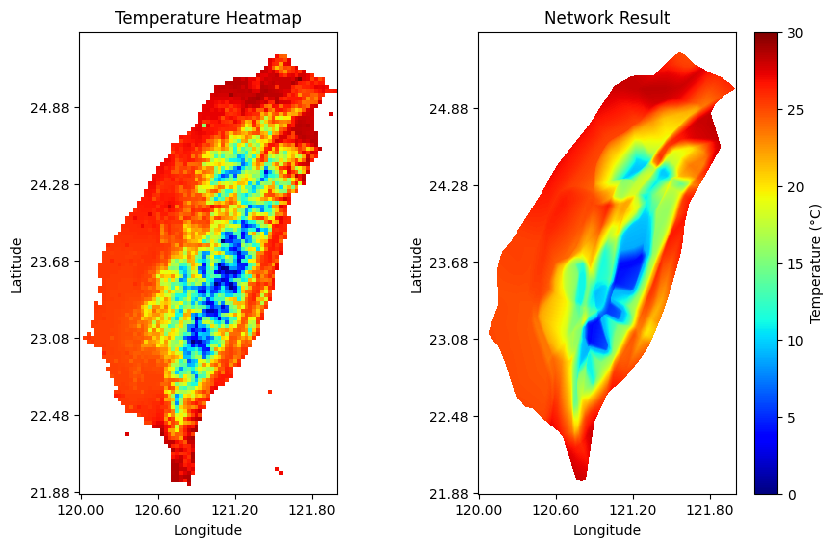

In [133]:
fig2, axes2 = plt.subplots(1, 2, figsize=(10, 6))

im1 = axes2[0].imshow(plot_data_3, origin='lower', cmap='jet', 
                      vmin=0, vmax=30, interpolation='nearest')
axes2[0].set_title("Temperature Heatmap")
axes2[0].set_xlabel("Longitude")
axes2[0].set_ylabel("Latitude")
axes2[0].set_xticks(xtick_org)
axes2[0].set_yticks(ytick_org)
axes2[0].set_xticklabels(xtick_label_org)
axes2[0].set_yticklabels(ytick_label_org)

im2 = axes2[1].imshow(plot_data_4, origin='lower', cmap='jet', 
                      vmin=0, vmax=30, interpolation='nearest')
fig2.colorbar(im2, ax=axes2[1], label="Temperature (°C)")
axes2[1].set_title("Network Result")
axes2[1].set_xlabel("Longitude")
axes2[1].set_ylabel("Latitude")
axes2[1].set_xticks(xtick_res)
axes2[1].set_yticks(ytick_res)
axes2[1].set_xticklabels(xtick_label_res)
axes2[1].set_yticklabels(ytick_label_res)

plt.savefig("./figure/model_result.png", dpi=300, bbox_inches='tight')
plt.show()

## Create Training Animation

In [132]:
model.drawAni("./figure/train_ani.gif")